# Linear SVM

We test the linear SVM class we implemented.

In [1]:
import matplotlib.pyplot as plt
%pylab inline

from sklearn.model_selection import train_test_split

import numpy as np

from SVM import SVM

Populating the interactive namespace from numpy and matplotlib


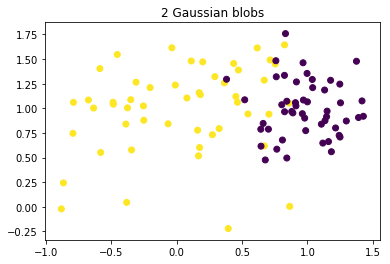

In [284]:
# Data generation
n_samples = 50

blob1 = np.random.multivariate_normal([0,1], 0.2*np.eye(2), n_samples)
blob2 = np.random.multivariate_normal([1,1], 0.07*np.eye(2), n_samples)

X = np.concatenate((blob1, blob2))
X = np.concatenate((X, np.ones((n_samples*2,1))), axis=1) # to account for offset
y = np.concatenate((np.ones(n_samples), -np.ones(n_samples)))

plt.scatter(X[:,0], X[:,1], c=y)
plt.title("2 Gaussian blobs")

In [285]:
# Train/test split, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42)

In [286]:
classif = SVM(tau=0.01)

In [287]:
classif.fit(X_train, y_train)

In [288]:
w_opt = classif.get_weights()

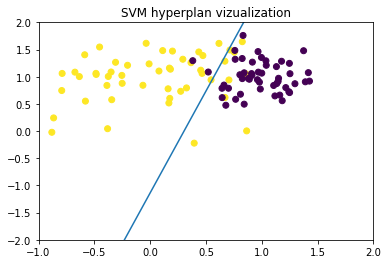

In [289]:
plt.scatter(X[:,0], X[:,1], c=y)

plt.plot(np.linspace(-5,5, 10), [-(w_opt[0]*x + w_opt[2])/w_opt[1] 
                                 for x in np.linspace(-5,5,10)])
plt.xlim(-1 ,2)
plt.ylim(-2, 2)
plt.title('SVM hyperplan vizualization')

In [290]:
X.shape

(100, 3)

# Kernel SVM

- Should we include an offset for the kernel SVM ?

In [263]:
from cvxopt import matrix
from cvxopt import solvers

SVM dual problem (slide 155) :

\begin{align}
\max_{\alpha \in \mathbb{R}^n} 2 \alpha^T y - \alpha^T K \alpha, \hspace{10pt} s.t. \hspace{10pt} 0 \leq y_i \alpha_i \leq \frac{1}{2\lambda n}
\end{align}

Equivalent to :

\begin{align}
\min_{\alpha \in \mathbb{R}^n} \alpha^T K \alpha - 2 \alpha^T y , \hspace{10pt} s.t. \hspace{10pt} 0 \leq y_i \alpha_i \leq \frac{1}{2\lambda n}
\end{align}

CVXOPT solves QP of the form :

\begin{align}
\min \frac{1}{2} x^T P x + q^T x \hspace{10pt} s.t. \hspace{10pt} Gx \leq h, Ax=b
\end{align}

SVM dual problem can be written as a generic QP with :
\begin{align}
P = 2K\\
q = -2y \\
G = \begin{pmatrix}diag(y)  \\ -diag(y) \end{pmatrix} \in \mathbb{R}^{2n \times n}\\
h = \frac{1}{2\lambda n} \begin{pmatrix} 1_n  \\ 0_n \end{pmatrix}
\end{align}


In [264]:
def build_kernel_matrix(X, pd_kernel):
    """
    Builds kernel matrix (K(x_i, x_j))_(i,j) given training data and a kernel
    X : training data matrix (Numpy array)
    pdf_kernel : a positive definite kernel (function)
    """
    n, d = X.shape
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1):
            K[i, j] = pd_kernel(X[i, :], X[j, :])
            K[j, i] = K[i, j]
    return K

In [265]:
def build_kernel_vector(X, x, pd_kernel):
    """
    Builds kernel vector (K(x, x_i))_i for a given vector x and training data 
    X : training data matrix (Numpy array)
    x : test point
    pdf_kernel : a positive definite kernel (function)
    """
    n, d = X.shape
    K_x = np.zeros(n)
    for i in range(n):
        K_x[i] = pd_kernel(X[i, :], x)
    return K_x

In [266]:
linear_kernel = lambda x, y: np.dot(x.T, y)

In [267]:
polynomial_kernel = lambda x,y : np.dot(x.T, y)**2

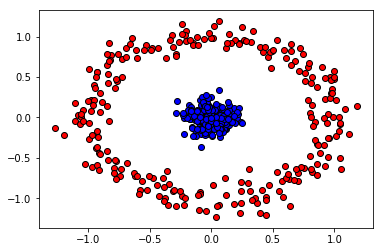

In [268]:
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn-datasets-make-circles
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, shuffle=True, noise=0.1, random_state=None, factor=0.01)
y = 2*y - np.ones(500) # to have either y=1 or y=-1

reds = y==-1
blues = y==1
plt.scatter(X[reds, 0], X[reds,1], color='r', edgecolor='k')
plt.scatter(X[blues, 0], X[blues,1], color='blue', edgecolor='k')

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42)

In [270]:
pd_kernel = polynomial_kernel

In [271]:
# linear kernel matrix
K = build_kernel_matrix(X_train, pd_kernel)

n = K.shape[0]
lambda_reg = 5 # regularization parameter

# D-SVM to generic QP
P = 2*K
q = -2*y_train
G = np.concatenate([np.diag(y_train), -np.diag(y_train)], axis=0)
h = np.concatenate([np.ones(n), np.zeros(n)])/(2*lambda_reg*n)
                
# Converts matrices and vectors to the right format for cvxopt solver
# cf http://cvxopt.org/userguide/coneprog.html for solver's doc
P_solver, q_solver = matrix(P), matrix(q)
G_solver, h_solver = matrix(G), matrix(h)
        
sol = solvers.qp(P=P_solver, q=q_solver, G=G_solver, h=h_solver)
alpha = np.array(sol['x'])  

In [276]:
y_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
    y_pred[i] = np.sign(np.dot(alpha.T, build_kernel_vector(X_train, X_test[i,:], pd_kernel)))

In [273]:
print('Prediction score : {}'.format(sum(y_pred == y_test)/len(y_test)*100))

Prediction score : 45.0
